<a href="https://colab.research.google.com/github/arunmuthulaksh/Text-2-Image/blob/main/Stroke_Coursework_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Load Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    mean_squared_error, r2_score, silhouette_score
)
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import linkage, dendrogram

from imblearn.over_sampling import SMOTE

plt.rcParams['figure.figsize'] = (8,5)


In [2]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 2. Descriptive Analytics

### 2.1 Dataset Overview

In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### 2.2 Target Variable Distribution

In [4]:
df['stroke'].value_counts(normalize=True) * 100

,proportion
stroke,
0,95.127202
1,4.872798


### 2.3 Visualisations

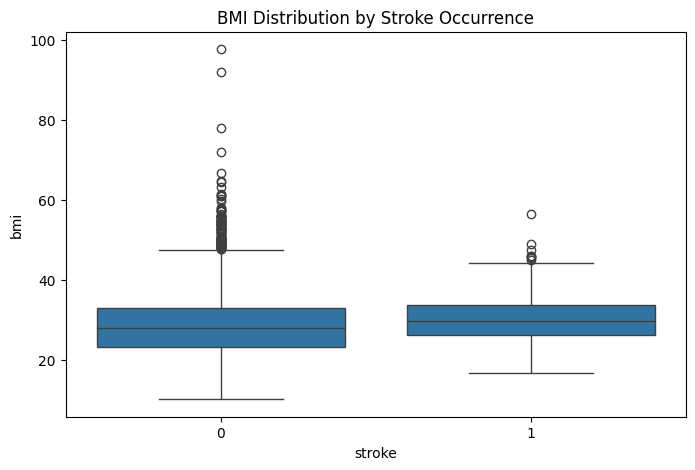

In [5]:
# Box plot: BMI vs Stroke
sns.boxplot(x='stroke', y='bmi', data=df)
plt.title("BMI Distribution by Stroke Occurrence")
plt.show()

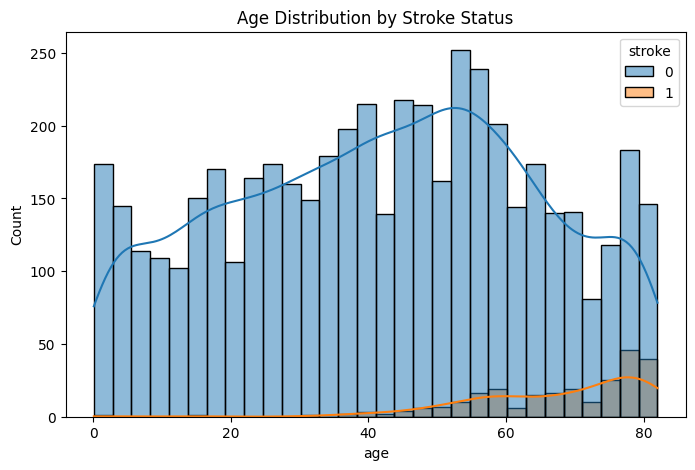

In [6]:
# Histogram: Age by Stroke
sns.histplot(data=df, x='age', hue='stroke', bins=30, kde=True)
plt.title("Age Distribution by Stroke Status")
plt.show()

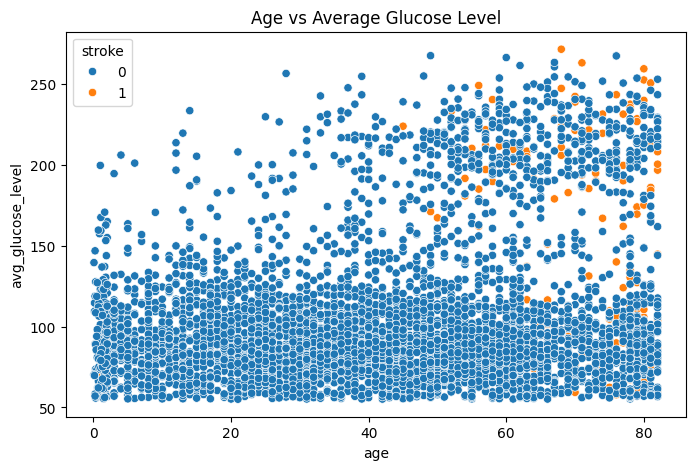

In [7]:
# Scatter plot: Age vs Glucose
sns.scatterplot(data=df, x='age', y='avg_glucose_level', hue='stroke')
plt.title("Age vs Average Glucose Level")
plt.show()

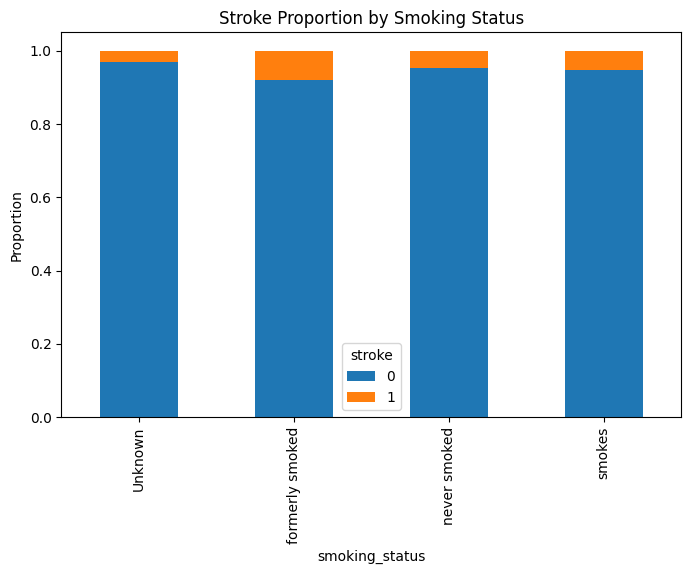

In [8]:
# Smoking status vs Stroke
pd.crosstab(df['smoking_status'], df['stroke'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Stroke Proportion by Smoking Status")
plt.ylabel("Proportion")
plt.show()

## 3. Data Preparation

In [9]:
# Drop ID column
df = df.drop(columns=['id'])

# Handle missing BMI values
df['bmi'].fillna(df['bmi'].median(), inplace=True)

# Outlier treatment using IQR
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1
df['bmi'] = np.clip(df['bmi'], Q1 - 1.5*IQR, Q3 + 1.5*IQR)

# Encode binary variables
df['ever_married'] = df['ever_married'].map({'Yes':1, 'No':0})
df['Residence_type'] = df['Residence_type'].map({'Urban':1, 'Rural':0})

# One-hot encoding
df = pd.get_dummies(df, columns=['gender','work_type','smoking_status'], drop_first=True)

# Feature scaling
scaler = StandardScaler()
num_cols = ['age','avg_glucose_level','bmi']
df[num_cols] = scaler.fit_transform(df[num_cols])

/tmp/ipython-input-1097923047.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['bmi'].fillna(df['bmi'].median(), inplace=True)


## 4. Classification – Stroke Prediction

In [10]:
X = df.drop(columns='stroke')
y = df['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [11]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_sm, y_train_sm)
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]

print("Logistic Regression")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.14      0.74      0.24        50

    accuracy                           0.77      1022
   macro avg       0.56      0.75      0.55      1022
weighted avg       0.94      0.77      0.83      1022

ROC-AUC: 0.828724279835391


In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_sm, y_train_sm)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

print("Random Forest")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

Random Forest
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       972
           1       0.14      0.24      0.18        50

    accuracy                           0.89      1022
   macro avg       0.55      0.58      0.56      1022
weighted avg       0.92      0.89      0.90      1022

ROC-AUC: 0.7651440329218107


In [13]:
# Support Vector Machine
svm = SVC(probability=True)
svm.fit(X_train_sm, y_train_sm)
y_pred = svm.predict(X_test)
y_prob = svm.predict_proba(X_test)[:,1]

print("SVM")
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

SVM
              precision    recall  f1-score   support

           0       0.97      0.80      0.88       972
           1       0.12      0.54      0.20        50

    accuracy                           0.79      1022
   macro avg       0.55      0.67      0.54      1022
weighted avg       0.93      0.79      0.85      1022

ROC-AUC: 0.7642798353909465


## 5. Regression – BMI Prediction

In [14]:
X_reg = df.drop(columns=['bmi','stroke'])
y_reg = df['bmi']

X_train, X_test, y_train, y_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

In [15]:
# Linear Regression
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
y_pred = lr_reg.predict(X_test)

print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

Linear Regression RMSE: 0.8539870383460022
R2: 0.2567194103814766


In [16]:
# Random Forest Regressor
rf_reg = RandomForestRegressor(random_state=42)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)

print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2:", r2_score(y_test, y_pred))

Random Forest RMSE: 0.8910757031388945
R2: 0.19075609459064657


## 6. Clustering

In [17]:
X_cluster = df.drop(columns=['stroke','bmi'])

In [18]:
# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_cluster)

print("Silhouette Score:", silhouette_score(X_cluster, labels))

Silhouette Score: 0.2595622505094381


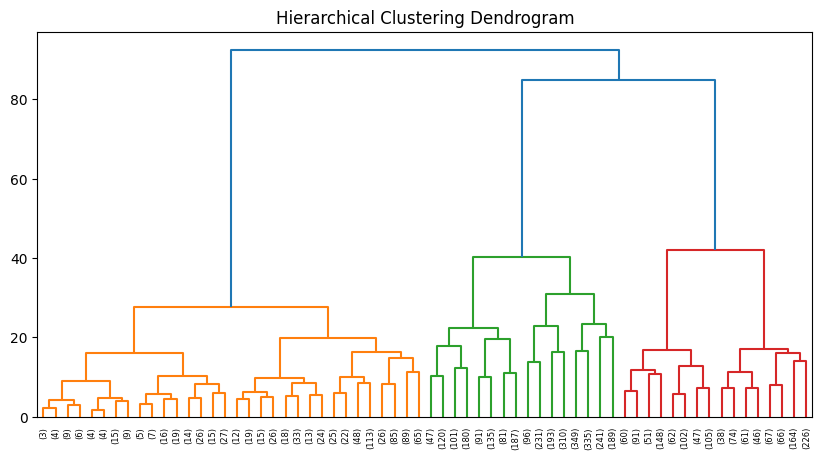

In [19]:
# Hierarchical Clustering Dendrogram
linkage_matrix = linkage(X_cluster, method='ward')
plt.figure(figsize=(10,5))
dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()